In [1]:
from pathlib import Path
import sys

# Add file path to environment for importing from the parent directory
sys.path.append("..")

In [2]:
from utils.test_utils import *
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc


In [3]:
# Get file path of Z

current_dir = Path.cwd()
parent_dir = current_dir.parents[0]
unsw_model_path = parent_dir / "results" / "UNSW" / "UNSW_model" / "Grassman_model_dim_2_std_client_20_iter_20_lr_0.0001_sub_0.1_localEpochs_30.npy"
ton_model_path = parent_dir / "results" / "TON" / "TON_model" / "Grassman_model_dim_2_std_client_20_iter_20_lr_0.0001_sub_0.1_localEpochs_30.npy"

In [9]:
unsw_model = np.load(unsw_model_path)
ton_model = np.load(ton_model_path)

In [5]:
# Test on ToN IoT
def ton_test(V_k):
  # Read data from csv files
  file_path_train = os.path.join(os.path.abspath('..'), "abnormal_detection_data/train/ton_train_normal_49.csv")
  file_path_test_normal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_test_normal_49.csv")
  file_path_test_abnormal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_test_abnormal_49.csv")
  df_train = pd.read_csv(file_path_train, index_col = 0)
  df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
  df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)
  df_test_normal = df_test_normal[:10000]
  
  df_test = pd.concat([df_test_normal, df_test_abnormal])
  df_test.columns = df_test_abnormal.columns

  # Standardization over Testing
  scaler = StandardScaler()
  scaler.fit(df_train)
  df_test = pd.DataFrame(scaler.transform(df_test))
  df_test.columns = df_test_abnormal.columns
  
  # FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
  df_test_transform = self_pca_transform_with_zero_mean(df_test, V_k)
  df_test_inverse = self_inverse_transform_with_zero_mean(df_test_transform, V_k)
  abnormal_score = anomalyScores_0_1(df_test, df_test_inverse)
  df_gt_score = pd.DataFrame(); df_gt_pred = pd.DataFrame()
  df_gt_score['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
  df_gt_score['anomalyScore'] = abnormal_score

  # Precision-Recall curves
  precision, recall, thresholds = precision_recall_curve(df_gt_score['ground_true'],df_gt_score['anomalyScore'])
  average_precision = average_precision_score(df_gt_score['ground_true'],df_gt_score['anomalyScore'])

  plt.figure(figsize=(5, 4));
  plt.step(recall, precision, color='k', alpha=0.7, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])

  plt.title('FedPCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
  plt.show()
  
  # RoC curve
  fpr, tpr, thresholds = roc_curve(df_gt_score['ground_true'], df_gt_score['anomalyScore'])
  areaUnderROC = auc(fpr, tpr)

  plt.figure(figsize=(5, 4));
  plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('FedPCA: ROC: Area under the curve = {0:0.4f}'.format(areaUnderROC))
  plt.legend(loc="lower right")
  plt.show()
  
  # Get results analysis
  lst_rho = np.linspace(1e-8,1e-7,10)
  # print(lst_rho)
  df = pd.DataFrame(np.zeros((len(lst_rho),6)))
  df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
  for i, rho in enumerate(lst_rho):
    precision_score, recall_score, accuracy_score, f1_score, fpr, _ = results_analysis(df_gt_score, threshold=rho, log=0)
    df.iloc[i,0] = rho
    df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

  return df

In [6]:
# Test on UNSW NB15
def unsw_nb15_test(V_k):
  # Read data from csv files
  file_path_train = os.path.join(os.path.abspath('..'), "abnormal_detection_data/train/unswnb15_train_normal.csv")
  file_path_test_normal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unswnb15_test_normal_full.csv")
  file_path_test_abnormal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unswnb15_test_abnormal.csv")
  df_train = pd.read_csv(file_path_train, index_col = 0)
  df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
  df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)

  df_test_normal = df_test_normal[:20000]
  df_test = pd.concat([df_test_normal, df_test_abnormal])
  df_test.columns = df_test_abnormal.columns

  # Standardization over Testing
  scaler = StandardScaler()
  scaler.fit(df_train)
  df_test = pd.DataFrame(scaler.transform(df_test))
  df_test.columns = df_test_abnormal.columns
  
  # FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
  df_test_transform = self_pca_transform_with_zero_mean(df_test, V_k)
  df_test_inverse = self_inverse_transform_with_zero_mean(df_test_transform, V_k)
  abnormal_score = anomalyScores_0_1(df_test, df_test_inverse)
  df_gt_score = pd.DataFrame(); df_gt_pred = pd.DataFrame()
  df_gt_score['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
  df_gt_score['anomalyScore'] = abnormal_score

  # Precision-Recall curves
  precision, recall, thresholds = precision_recall_curve(df_gt_score['ground_true'],df_gt_score['anomalyScore'])
  average_precision = average_precision_score(df_gt_score['ground_true'],df_gt_score['anomalyScore'])

  plt.figure(figsize=(5, 4));
  plt.step(recall, precision, color='k', alpha=0.7, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])

  plt.title('FedPCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
  plt.show()
  
  # RoC curve
  fpr, tpr, thresholds = roc_curve(df_gt_score['ground_true'], df_gt_score['anomalyScore'])
  areaUnderROC = auc(fpr, tpr)

  plt.figure(figsize=(5, 4));
  plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('FedPCA: ROC: Area under the curve = {0:0.4f}'.format(areaUnderROC))
  plt.legend(loc="lower right")
  plt.show()
  
  # Get results analysis
  lst_rho = np.linspace(0.0000001,0.00001,10)
  print(lst_rho)
  df = pd.DataFrame(np.zeros((len(lst_rho),6)))
  df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
  for i, rho in enumerate(lst_rho):
    precision_score, recall_score, accuracy_score, f1_score, fpr, _ = results_analysis(df_gt_score, threshold=rho, log=0)
    df.iloc[i,0] = rho
    df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

  return df

In [7]:
def visual_rho_effect(df):
    plt.figure(figsize=(5, 4));
    plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
    plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
    plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
    plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
    plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
    plt.xlabel(r'$\rho$')
    plt.ylabel('Performance')
    # plt.xticks(xticks)
    # plt.legend(loc = 'lower right')
    plt.legend()
    plt.grid()
    plt.title("Performance of FedPCA with different percentage threshold p")
    # plt.savefig("results-rho.eps",format='eps',bbox_inches='tight')
    plt.show()

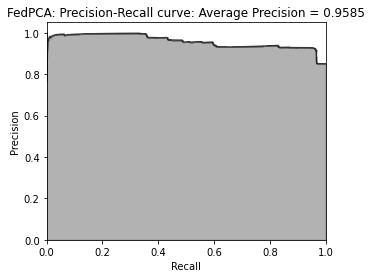

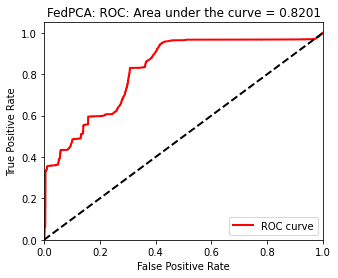

In [89]:
ton_df = ton_test(ton_model)

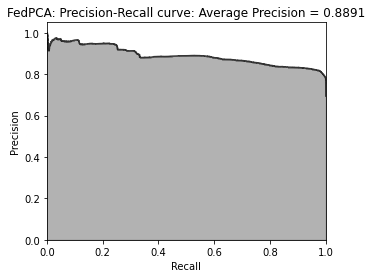

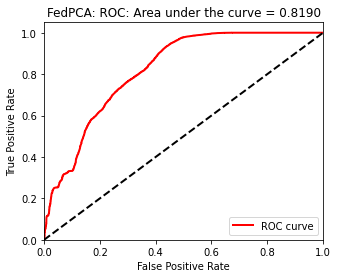

[1.0e-07 1.2e-06 2.3e-06 3.4e-06 4.5e-06 5.6e-06 6.7e-06 7.8e-06 8.9e-06
 1.0e-05]


In [90]:
unsw_df = unsw_nb15_test(unsw_model)

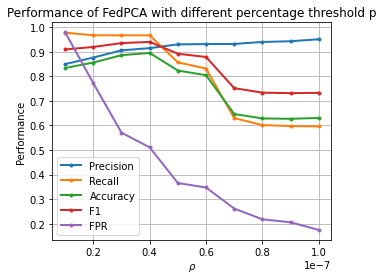

In [91]:
visual_rho_effect(ton_df)

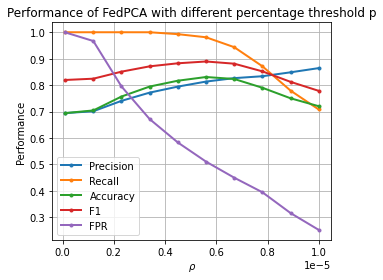

In [92]:
visual_rho_effect(unsw_df)